In [103]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import math

from pandas import read_csv
from scipy.optimize import curve_fit
import pickle

import czifile
import cv2
import multiprocessing
import pickle


In [2]:
video_time_length=60 #s
imgname='#4_fus_639nm_75h_1min_1116p2um'
foldername='/Volumes/T7_Shield/Speckle_more/June_FUS/20230609/'

# Read the CZI file
data = czifile.imread(foldername+imgname+'.czi')
framespeed=video_time_length/data.shape[1]

# apply a gaussian blur
for t in range(0,data.shape[1],1):
    data[0,t,0,0,:,:,0]=cv2.GaussianBlur(data[0,t,0,0,:,:,0], (3, 3), 1.6)

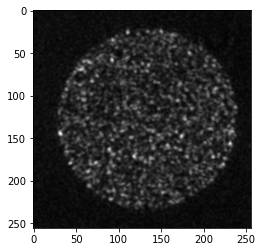

In [3]:
plt.imshow(data[0, 1, 0, 0, :, :, 0], cmap='gray')
plt.show()

In [4]:
def vectorized_compute_g2t_wo_kernel(px_indices, laglist_g2t, start_t, max_t_range, data, normalize=True, plot=False):
    print(px_indices)
    # Extract the intensity values for all px indices at once
    # Assuming 'data' is a 5D array and px_indices is a 2D array with shape (n, 2)
    intensities = data[0, :, 0, 0, px_indices[:, 0], px_indices[:, 1], 0]
    
    intensities = intensities.astype(np.uint64)
    # print(intensities.shape)
    
    g2t_results = np.zeros((px_indices.shape[0], len(laglist_g2t)))

    # Loop over laglist_g2t
    for idx, lag in enumerate(laglist_g2t):
        # Vectorized computation for numerator and denominator
        numerator = (intensities[:, start_t:start_t + max_t_range] * intensities[:, start_t + lag:start_t + max_t_range + lag]).mean(axis=1)
        
        denominator1 = intensities[:, start_t:start_t + max_t_range].mean(axis=1)
        denominator2 = intensities[:, start_t + lag:start_t + max_t_range + lag].mean(axis=1)
        g2t_results[:, idx] = (np.array(numerator[:]) / (np.array(denominator1[:]) * np.array(denominator2[:]))) - 1

    # Normalization
    if normalize:
        first = g2t_results[:, 0].reshape(-1, 1)  # Reshape 'first' to be a column vector
        g2t_results /= first
    # if normalize:
    #     first = g2t_results[:, 0]
    #     for idx, lag in enumerate(laglist_g2t):
    #         g2t_results[:, idx] /= first


    # Plotting (if required)
    if plot:
        plt.figure(figsize=(8,5))
        for intensity in intensities:
            plt.plot(intensity[:200], 'k-')
        plt.xlabel("Time point", fontsize=18)
        plt.ylabel("Intensity", fontsize=18)
        plt.tick_params(direction='in')
        plt.show()

    return g2t_results


In [5]:

# Assuming 'data' is a NumPy array and 'compute_g2t_wo_kernel' is vectorized
h, w = 250,250  # Assuming data has at least 4 dimensions and spatial dimensions are at 2nd and 3rd
corrmaps_v = np.empty((h, w), dtype=object)  # or the appropriate dtype for your data
max_lag=200
laglist_g2t = np.arange(0, max_lag, 1)

# Create a grid of indices for the entire array
i_indices, j_indices = np.indices((h, w))

# Vectorized computation for the whole array
results = vectorized_compute_g2t_wo_kernel(np.stack((i_indices, j_indices), axis=-1).reshape(-1, 2),
                                laglist_g2t, 0, 900, data)

# # Reshape results to match the 2D structure of corrmaps
corrmaps_v = results.reshape(h, w, max_lag)


[[  0   0]
 [  0   1]
 [  0   2]
 ...
 [249 247]
 [249 248]
 [249 249]]


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_75610/2172937618.py:1: RuntimeWarning: invalid value encountered in log
  plt.plot(np.array(time_data)**0.4,np.log(corrmaps_v[29][93]),'.')


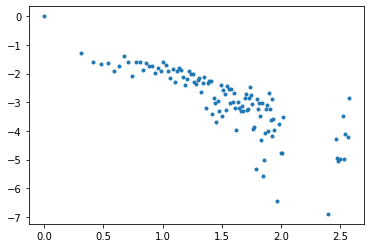

In [67]:
plt.plot(np.array(time_data)**0.4,np.log(corrmaps_v[29][93]),'.')

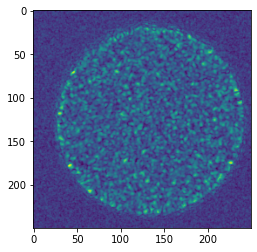

In [7]:
plt.imshow(corrmaps_v[:,:,30])

## find best beta

In [8]:
def create_circular_mask(h, w, center, radius):
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask


In [44]:
h=250
w=250
mask = create_circular_mask(h, w, [134,126],106)

In [69]:
def stretched_exponential(t, tau, beta):
    return np.exp(-(t / tau)**beta)

def fit_stretched_exponential(time_data, y_data):

    # Perform the curve fitting
    params, covariance = curve_fit(stretched_exponential, time_data[:15], y_data[:15],p0=[0.2,0.5])

    # Extracting the parameters
    tau, beta = params
    return tau, beta


In [70]:
tau_map = np.zeros((h,w))
beta_map = np.zeros((h,w))
time_data = [ele *framespeed for ele in laglist_g2t]
for i in range(h):
    for j in range(w):
        if mask[i,j]:
            print(i,j)
            tau_map[i,j]=fit_stretched_exponential(time_data, corrmaps_v[i][j])[0]
            beta_map[i,j]=fit_stretched_exponential(time_data, corrmaps_v[i][j])[1]
            print(tau_map[i,j])
                

20 134
0.009901349139974671
21 120
37.79532325066718
21 121
1.0472985505492654
21 122
0.3389794501981723
21 123
0.3110779086506964
21 124
0.1983635340057147
21 125
0.09280012424718205
21 126
0.2469527515798666
21 127
0.39287728404550637
21 128
0.8183715391622902
21 129
2.5537381393848007
21 130
8.401477230052436
21 131
7.706797272040477
21 132
2.0974162070767943
21 133
0.3656900962104939
21 134
0.36626766149347856
21 135
0.31576243248767294
21 136
0.18287576404527797
21 137
1.591665416383368
21 138
4.50438414306367
21 139
2.591489119587232
21 140
0.3031129848498115
21 141
0.1686926219821603
21 142
0.1308809935819331
21 143
0.16762624981595828
21 144
0.1602596876354762
21 145
0.287771457089779
21 146
0.27473772079164993
21 147
0.2281000907728447
21 148
0.20322966792010005
22 114
0.06938231877131605
22 115
0.029538944188458545
22 116
0.21117320716373156
22 117
0.6224647422766112
22 118
0.8539929400359115
22 119
0.7441869506362558
22 120
0.5006866513653387
22 121
0.470743200699312
22 122


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_75610/83435628.py:2: RuntimeWarning: divide by zero encountered in power
  return np.exp(-(t / tau)**beta)
/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_75610/83435628.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / tau)**beta)



26 115
0.13039683262951912
26 116
0.22720753298777296
26 117
0.18387193319551084
26 118
0.10090077854131449
26 119
0.05492044352345594
26 120
0.09204899469696039
26 121
0.14282127263416786
26 122
0.16999301112113496
26 123
0.28512065869723696
26 124
0.5727471444805341
26 125
0.9255197734191786
26 126
1.144856176738391
26 127
0.8417406311958539
26 128
0.1708416356004558
26 129
0.12838495544073691
26 130
0.4858415470415586
26 131
0.8939018248415405
26 132
0.5605498731769232
26 133
0.2044696091378069
26 134
0.23614863496184024
26 135
0.34526937311556777
26 136
0.44497237988667404
26 137
0.5725769709299778
26 138
0.4810627238760339
26 139
0.5205703020481771
26 140
0.4010358368964443
26 141
0.39239830710436824
26 142
0.7657606361733695
26 143
1.3949068218118428
26 144
1.799760357069877
26 145
0.3914252981917815
26 146
0.07051054734770891
26 147
0.09592904674849628
26 148
0.12959921913778755
26 149
0.32036028698286884
26 150
0.4255615372087426
26 151
0.2485931171652743
26 152
0.137654894610

In [83]:
from scipy import stats

In [88]:
# Exclude zero values
beta_map_non_zero = beta_map[beta_map != 0]

# Flatten the array
beta_map_flattened = beta_map_non_zero.flatten()

median_value = np.median(beta_map_non_zero)
median_value

0.3337655226848862

(array([3.9000e+01, 5.6200e+02, 4.6590e+03, 1.1551e+04, 1.1189e+04,
        5.3890e+03, 1.4800e+03, 3.2200e+02, 6.6000e+01, 8.0000e+00]),
 array([0.05782555, 0.12571378, 0.19360201, 0.26149024, 0.32937847,
        0.3972667 , 0.46515493, 0.53304316, 0.60093139, 0.66881962,
        0.73670785]),
 <BarContainer object of 10 artists>)

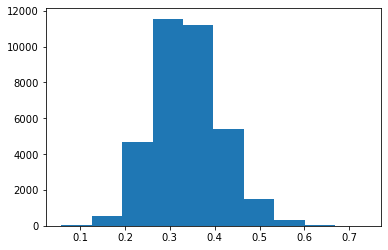

In [87]:
plt.hist(beta_map_flattened, bins=10) 

## getting characteric time

In [97]:
def stretched_exponential_tau(t, tau):
    return np.exp(-(t / tau)**0.33)

def fit_stretched_exponential_tau(time_data, y_data):

    # Perform the curve fitting
    tau, covariance = curve_fit(stretched_exponential_tau, time_data[:15], y_data[:15],p0=0.2)
    
    return tau

In [98]:
tau_map_result = np.zeros((h,w))
time_data = [ele *framespeed for ele in laglist_g2t]
for i in range(h):
    for j in range(w):
        if mask[i,j]:
            print(i,j)
            tau_map_result[i,j]=fit_stretched_exponential_tau(time_data, corrmaps_v[i][j])
            print(tau_map_result[i,j])

20 134
0.05196553464820467
21 120
1.0632582028611677
21 121
0.586281574072628
21 122
0.3379027865835551
21 123
0.3146488573654596
21 124
0.24416698169232431
21 125
0.14785036205533628
21 126
0.260559782966869
21 127
0.3762863312268959
21 128
0.5711337534808587
21 129
1.3399699068351234
21 130
3.5212670493562257
21 131
4.562789698382607
21 132
1.7487779848577885
21 133
0.3581528272345139
21 134
0.36101528620362133
21 135
0.3183677280965664
21 136
0.20220116658282242
21 137
1.0257306054223596
21 138
2.2799693879370078
21 139
1.2398918787132367
21 140
0.30876943900475373
21 141
0.16244212641196085
21 142
0.1542683873325543
21 143
0.21861518431517118
21 144
0.21341020822310078
21 145
0.2986081835886516
21 146
0.2888787529015431
21 147
0.24657034003355752
21 148
0.21779569722071881
22 114
0.14659295005650927
22 115
0.0694829117122662
22 116
0.25522417194900393
22 117
0.5014233046945116
22 118
0.6201477462764623
22 119
0.5351470931270658
22 120
0.42301345127673906
22 121
0.43773795546908495


/var/folders/wf/qxrbnsmd4xn7cplm95fm264w0000gn/T/ipykernel_75610/3832240142.py:2: RuntimeWarning: invalid value encountered in power
  return np.exp(-(t / tau)**0.33)


0.062014639203914035
28 174
0.05826722580206094
29 92
0.04590691532856517
29 93
0.060873743219369426
29 94
0.05102311960686163
29 95
0.07781226907419911
29 96
0.3146076145913191
29 97
0.45807853369592305
29 98
0.585079651366027
29 99
0.543670059969758
29 100
0.404400816782738
29 101
0.509731574175618
29 102
1.3546509960663844
29 103
0.8307599915524571
29 104
0.27165769886724306
29 105
0.33779679353144343
29 106
0.5435473021678556
29 107
0.3753931282987073
29 108
0.20676782710305985
29 109
0.14256203552795488
29 110
0.17280778966045057
29 111
0.16692346552017542
29 112
0.11017490620999597
29 113
0.0611336641848002
29 114
0.07316729499517094
29 115
0.10526131375314675
29 116
0.09560119682085465
29 117
0.10103439593761022
29 118
0.08433337324926095
29 119
0.07122250574109461
29 120
0.07925976532002307
29 121
0.09859252857987617
29 122
0.1548038352488926
29 123
0.2239902321250672
29 124
0.24082104917043665
29 125
0.1584191166528237
29 126
0.10676438954300163
29 127
0.08062040809490065
29 1

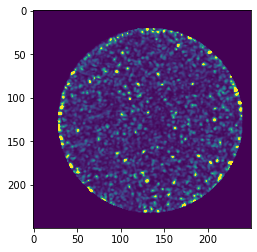

In [101]:
plt.imshow(tau_map_result,vmin=0, vmax=1.5)

In [ ]:
with open(imgname+'beta_map.pkl', 'wb') as file:
    pickle.dump(beta_map, file)